import libraries

In [103]:
import pandas as pd
import glob
import json
from pandas import json_normalize
from ast import literal_eval
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('max_columns', None)

read data

In [11]:
filename = 'train.csv'
def read_file(file):
    dtypes = {'date':'str','fullVisitorId': 'str'}
    parse_dates = ['date']
    USE_COLUMNS = [
        'channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
        'socialEngagementType', 'totals', 'trafficSource', 'visitId',
        'visitNumber', 'visitStartTime',
    ]
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(file, dtype = dtypes, parse_dates = parse_dates,
                    converters={column: json.loads for column in JSON_COLUMNS},
                    usecols=USE_COLUMNS)
    
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    
    drop_cols = [
    'socialEngagementType',
    
    'device_browserSize',
    'device_operatingSystemVersion',
    'device_mobileDeviceBranding',
    'device_mobileDeviceModel',
    'device_mobileInputSelector',
    'device_mobileDeviceInfo',
    'device_mobileDeviceMarketingName',
    'device_flashVersion',
    'device_language',
    'device_screenColors',
    'device_screenResolution',
    
    'geoNetwork_cityId',
    'geoNetwork_latitude',
    'geoNetwork_longitude',
    'geoNetwork_networkLocation',
    
    'totals_visits',
    
    'trafficSource_adwordsClickInfo.criteriaParameters',
    ]
    
    df = df.drop(drop_cols,axis=1)
    return df

In [27]:
df = read_file(filename)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 40 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   channelGrouping                               903653 non-null  object        
 1   date                                          903653 non-null  datetime64[ns]
 2   fullVisitorId                                 903653 non-null  object        
 3   visitId                                       903653 non-null  int64         
 4   visitNumber                                   903653 non-null  int64         
 5   visitStartTime                                903653 non-null  int64         
 6   year                                          903653 non-null  int64         
 7   month                                         903653 non-null  int64         
 8   day                                           903653 n

In [29]:
# --fill missing values--
def fill_missing(df):
    values = {
              'totals_transactionRevenue' : 0,
              'trafficSource_adwordsClickInfo.isVideoAd' : True,
              'trafficSource_isTrueDirect' : False,
              'trafficSource_keyword' : '(not provided)',
              'totals_pageviews' : 1, 
              'totals_bounces':0,
              'totals_newVisits':0,
              'totals_timeOnSite':0,
              'totals_transactionRevenue':0
             }
    df = df.fillna(value=values)
    
    # --convert type--
    df = df.astype({
                'totals_hits': 'int64',
                'totals_pageviews': 'int64',
                'totals_newVisits': 'int64',
                'totals_transactionRevenue': 'int64',
                'totals_bounces': 'int64',})
    return df

In [30]:
clean_df = fill_missing(df)

### feature engineering

'totals_transactionRevenue' / 100000<br>
because Total transaction revenue, expressed as the value passed to Analytics multiplied by 10^6 (e.g., 2.40 would be given as 2400000).

In [32]:
clean_df['totals_transactionRevenue'] = clean_df['totals_transactionRevenue'].apply(lambda x: x/1000000) #apply along the row (axis=1)

group by user

In [38]:
# Grouping by CustomerID
data_process = clean_df.groupby(['fullVisitorId']).agg({
        'fullVisitorId': 'count',
        'totals_hits': 'sum',
        'totals_transactionRevenue':'sum'
})
# Rename the columns 
data_process.rename(columns={
                         'fullVisitorId': 'total visits',
                         'totals_hits': 'totals_hits',
                         'totals_transactionRevenue':'total purchases value'
                    }, inplace=True)

In [56]:
clean_df['date'].max()

Timestamp('2017-08-01 00:00:00')

In [57]:
clean_df['date'].min()

Timestamp('2016-08-01 00:00:00')

In [39]:
data_process['recent_visit_date'] = clean_df.groupby('fullVisitorId').agg({'date':'max'})
data_process['first_visit_date'] = clean_df.groupby('fullVisitorId').agg({'date':'min'})
data_process['total_transactionRevenue'] = clean_df.groupby('fullVisitorId').agg({'totals_transactionRevenue':'sum'})
data_process['max_transactionRevenue'] = clean_df.groupby('fullVisitorId').agg({'totals_transactionRevenue':'max'})
data_process['min_transactionRevenue'] = clean_df.groupby('fullVisitorId').agg({'totals_transactionRevenue':'min'})
data_process['avg_transactionRevenue'] = clean_df.groupby('fullVisitorId').agg({'totals_transactionRevenue':'mean'})

In [59]:
data_process['avg_hits'] = clean_df.groupby('fullVisitorId').agg({'totals_hits':'mean'})

In [62]:
data_process['total_pageviews']=clean_df.groupby('fullVisitorId').agg({'totals_pageviews':'sum'})
data_process['avg_pageviews']=clean_df.groupby('fullVisitorId').agg({'totals_pageviews':'mean'})

In [174]:
data_process['Length of relationship'] = (pd.to_datetime('2017-08-01')-data_process['first_visit_date']).dt.days

In [175]:
data_process['days_since_most_recent_visit']=(pd.to_datetime('2017-08-01')-data_process['recent_visit_date']).dt.days

In [65]:
data_process['return_user'] = data_process.apply(lambda x: 1 if x['visit frequency'] > 1 else 0, axis=1)

In [185]:
data_process['non_purchse_times'] = clean_df.groupby('fullVisitorId')['totals_transactionRevenue'].agg(lambda x: x.eq(0).sum())

In [209]:
data_process['purchase_times'] = data_process['visit frequency'] - data_process['non_purchse_times']

In [186]:
data_process.info()

<class 'pandas.core.frame.DataFrame'>
Index: 714167 entries, 0000010278554503158 to 9999986437109498564
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   visit frequency               714167 non-null  int64         
 1   totals_hits                   714167 non-null  int64         
 2   total purchases value         714167 non-null  float64       
 3   recent_visit_date             714167 non-null  datetime64[ns]
 4   first_visit_date              714167 non-null  datetime64[ns]
 5   total_transactionRevenue      714167 non-null  float64       
 6   max_transactionRevenue        714167 non-null  float64       
 7   min_transactionRevenue        714167 non-null  float64       
 8   avg_transactionRevenue        714167 non-null  float64       
 9   Length of relationship        714167 non-null  int64         
 10  days_since_most_recent_visit  714167 non-null  int64  

In [212]:
return_df = data_process.groupby(['return_user']).agg({
        'total purchases value': 'sum',
        'days_since_most_recent_visit': 'mean',
        'max_transactionRevenue':'max',
        'non_purchse_times':'sum',
        'visit frequency':'sum',
        'purchase_times':'sum',
        
})
# Rename the columns 
return_df.rename(columns={
                         'total purchases value': 'total purchases value',
                         'days_since_most_recent_visit': 'days_since_most_recent_visit',
                         'max_transactionRevenue':'max_transactionRevenue',
                         'non_purchse_times':'non_purchse_times',
                         'visit frequency':'total visits',
                         'purchase_times':'purchase_times'
                        
                    }, inplace=True)


In [203]:
return_df['non_purchse_times_rate'] =  return_df['non_purchse_times']/return_df['total visits']
return_df['avg_transactionRevenue'] = return_df['total purchases value']/return_df['purchase_times']

In [208]:
return_df.drop(['non_purchse_times','total visits','purchase_times'],axis=1)

,total purchases value,days_since_most_recent_visit,max_transactionRevenue,avg_transactionRevenue,non_purchse_times_rate
return_user,,,,,
0,237084.23,195.622405,3026.1,0.381978,0.994973
1,1302987.01,173.248310,23129.5,3.000401,0.970333


visualization

return users and non return users distribution

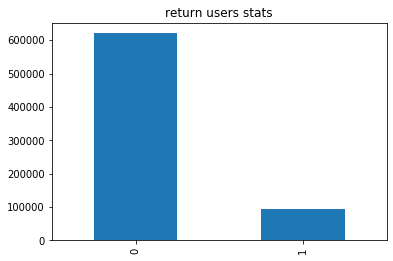

In [107]:
plot = data_process['return_user'].value_counts().plot.bar(title='return users stats')
plot.set_facecolor('white') 

Text(0.5, 0, 'avg spending')

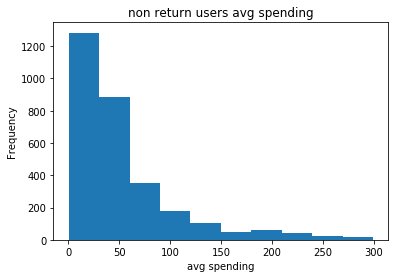

In [93]:
plot = data_process[(data_process['return_user']==0) & (data_process['total purchases value']>0)&(data_process['total purchases value']<300)]['avg_transactionRevenue'].plot(kind='hist',title='non return users avg spending')
plot.set_xlabel("avg spending")

Text(0.5, 0, 'avg spending')

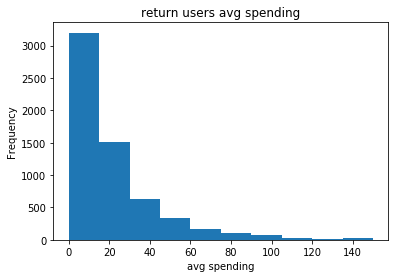

In [92]:
plot = data_process[(data_process['return_user']==1) & (data_process['total purchases value']>0)&(data_process['total purchases value']<300)]['avg_transactionRevenue'].plot(kind='hist',title='return users avg spending')
plot.set_xlabel("avg spending")

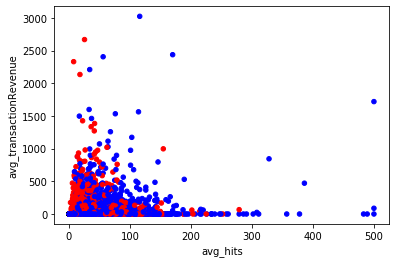

In [100]:
colors = {1:'red',0:'blue'}
plot = data_process.plot.scatter(x='avg_hits',
                      y='avg_transactionRevenue',
                      c=data_process['return_user'].map(colors))
                      

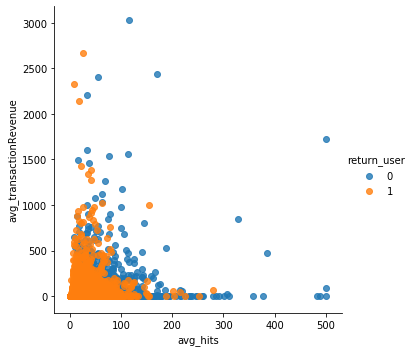

In [104]:
sns.lmplot('avg_hits', 'avg_transactionRevenue', data=data_process, hue='return_user', fit_reg=False)
plt.show()

total purchase pre channel

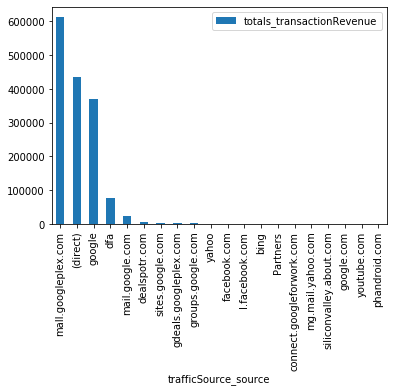

In [147]:
data = clean_df.groupby('trafficSource_source').agg({'totals_transactionRevenue':'sum'})
data = data[data['totals_transactionRevenue']>0].sort_values(by='totals_transactionRevenue',ascending=False)
data = data[:20]
plot = data.plot(kind='bar')

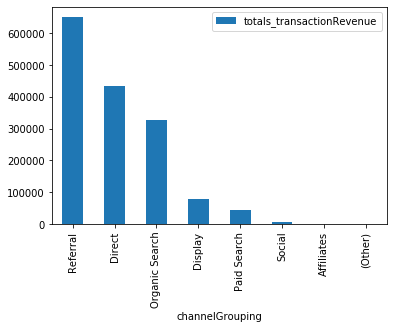

In [146]:
data = clean_df.groupby('channelGrouping').agg({'totals_transactionRevenue':'sum'}).sort_values(by='totals_transactionRevenue',ascending=False)
plot = data.plot(kind='bar')

In [ ]:
agg({'totals_transactionRevenue':'sum'})